In [1]:
# Run the notebook so its functions exist in the current namespace (not as a module)
%run adapters.ipynb
%run providers.ipynb

# now you can just call make_call_model_fn(...) directly since it's defined in the notebook


In [16]:
# message_opt_sim.py
import json
import os
import simpy, math, random, heapq, hashlib
import matplotlib.pyplot as plt
import pandas as pd
import ollama
from dataclasses import dataclass
from typing import Optional, Callable
from collections import defaultdict
from math import isfinite

BITS_PER_BYTE = 8

os.environ["OLLAMA_MODEL"] = "phi3:mini"   # "llama3.1" was a previous model but it ran too slow "qwen2.5:7b-instruct", etc.

# -------------------- Link (network channel) --------------------
class Link:
    def __init__(self, env, u, v, bandwidth_bps, prop_delay_ms, capacity=32):   #udpated smaller queue depth
        self.env = env
        self.u, self.v = u, v
        self.bps = bandwidth_bps
        self.prop = prop_delay_ms / 1000.0
        self.q = simpy.Store(env, capacity=capacity)   # finite queue -> backpressure
        self.bytes_sent = 0
        self.messages_sent = 0
        self.max_q_depth = 0
        env.process(self.run())

    def send(self, size_bytes, payload):
        # put() blocks if queue is full -> natural backpressure
        self.bytes_sent += size_bytes
        self.messages_sent += 1
        self.max_q_depth = max(self.max_q_depth, len(self.q.items) + 1)
        return self.q.put((size_bytes, payload))

    def run(self):
        while True:
            size_bytes, payload = (yield self.q.get())
            ser = (size_bytes * BITS_PER_BYTE) / self.bps
            yield self.env.timeout(ser + self.prop)
            payload["dst"].inbox.put(payload)

# -------------------- Queue-aware Rule Policy --------------------
class RulePolicy:
    """
    Realistic queue-aware policy:
      - If tiny improvement and link is busy -> SKIP (shed low-value load)
      - If queue has backlog -> AGGREGATE (batch for a short window)
      - If small improvement -> COMPRESS (smaller payload)
      - Else -> ALLOW
    """
    def __init__(self, eps_small=0.05, eps_med=0.20, q_hi=1, agg_ms=20):
        self.eps_small = eps_small
        self.eps_med = eps_med
        self.q_hi = q_hi
        self.agg_ms = agg_ms

    def decide(self, *, delta, queue_depth, util=None):
        if delta < self.eps_small and queue_depth > 0:
            return "SKIP", None, None
        if queue_depth >= self.q_hi:
            return "AGGREGATE", self.agg_ms, None
        if delta < self.eps_med:
            return "COMPRESS", None, 48  # bytes
        return "ALLOW", None, 96         # bytes

# -------------------- Node (distributed process) --------------------
class Node:
    def __init__(self, env, node_id, controller, policy):
        self.env = env
        self.id = node_id
        self.ctrl = controller
        self.policy = policy                    # may be None for baseline
        self.neighbors = {}                     # v -> (link, weight)
        self.inbox = simpy.Store(env)
        self.dist = defaultdict(lambda: math.inf)
        self.last_sent = defaultdict(lambda: math.inf)  # best value last sent per (v,s)
        self.pending = {}                       # aggregation buffers
        self.action_counts = defaultdict(int)   # instrumentation
        env.process(self.recv_loop())

    def add_neighbor(self, v, link, w):
        self.neighbors[v] = (link, w)

    def init_source(self, s):
        if self.id == s:
            self.dist[s] = 0.0
            for v,(link,w) in self.neighbors.items():
                self._maybe_send(v, s, self.dist[s] + w)

    def _enqueue_send(self, link, payload, size_bytes):
        self.ctrl.inflight += 1
        link.send(size_bytes, payload)

    def _maybe_send(self, v, s, d):
        link,_ = self.neighbors[v]

        # Baseline: always send full message
        if self.policy is None:
            msg = {"kind":"RELAX","src":self,"dst":self.ctrl.nodes[v],"s":s,"d":d}
            self.last_sent[(v,s)] = d
            self._enqueue_send(link, msg, self.ctrl.size_model("RELAX"))
            return

        old = self.last_sent[(v,s)]
        delta = abs(d - old)
        queue_depth = len(link.q.items)

        action, param, size_bytes = self.policy.decide(
        delta=delta, queue_depth=queue_depth, util=None
        )
        # action, param, size_bytes = self.policy.decide(
        #     delta=delta, queue_depth=queue_depth, util=None
        # )

        # TEMP sanity: don’t allow silent coercion to ALLOW
        assert action in ("ALLOW","COMPRESS","AGGREGATE","SKIP"), f"bad action {action}"
        # TEMP
        
        self.action_counts[action] += 1
        if action == "SKIP":
            return

        if action == "AGGREGATE":
            key = (v,s)
            self.pending[key] = d
            if ("timer", key) not in self.pending:
                self.pending[("timer", key)] = True
                self.env.process(self._aggregate_after(param, v, s, link))
            return

        # ALLOW/COMPRESS -> send immediately
        send_size = size_bytes if size_bytes is not None else self.ctrl.size_model("RELAX")
        msg = {"kind":"RELAX","src":self,"dst":self.ctrl.nodes[v],"s":s,"d":d}
        self.last_sent[(v,s)] = d
        self._enqueue_send(link, msg, send_size)

    def _aggregate_after(self, delay_ms, v, s, link):
        yield self.env.timeout(delay_ms / 1000.0)
        key = (v,s)
        if key in self.pending:
            d = self.pending.pop(key)
            _ = self.pending.pop(("timer", key), None)
            send_size = self.ctrl.size_model("RELAX")
            msg = {"kind":"RELAX","src":self,"dst":self.ctrl.nodes[v],"s":s,"d":d}
            self.last_sent[(v,s)] = d
            self._enqueue_send(link, msg, send_size)
        else:
            _ = self.pending.pop(("timer", key), None)

    def recv_loop(self):
        while True:
            msg = (yield self.inbox.get())
            self.ctrl.inflight -= 1
            if msg["kind"] == "RELAX":
                s, d = msg["s"], msg["d"]
                if d < self.dist[s]:
                    self.dist[s] = d
                    for v,(link,w) in self.neighbors.items():
                        self._maybe_send(v, s, self.dist[s] + w)



#-------------------------------------------------------------------------------------------------------------------------------------------------#


class LLMPolicy:
    """
    Real-LLM policy stub:
    - Bins features (delta, queue_depth) to reduce distinct prompts.
    - Calls `call_model_fn(prompt: str) -> str` that returns a JSON decision.
    - Returns (action, param, size_bytes) like other policies.
    """
    def __init__(self,
                 call_model_fn,
                 bins_delta=(0.02, 0.1, 0.5, 1.0),
                 bins_q=(0, 1, 2, 4, 8),
                 agg_ms_choices=(5, 10, 20),
                 compress_size=48,
                 full_size=96,
                 use_cache=True):
        self.call_model_fn = call_model_fn
        self.bins_delta = tuple(sorted(bins_delta))
        self.bins_q = tuple(sorted(bins_q))
        self.agg_ms_choices = agg_ms_choices
        self.compress_size = compress_size
        self.full_size = full_size
        self.use_cache = use_cache
        self._cache = {}  # (delta_bin, q_bin) -> (action, param, size_bytes)
        
    # ---- helpers ----
    def _bin(self, x, edges):
        # place x into a discrete bin index: 0..len(edges)
        for i, e in enumerate(edges):
            if x < e:
                return i
        return len(edges)

    # Inside class LLMPolicy ...
    def decide(self, delta, queue_depth, util=None):
        """
        Return a tuple: (action, param, size_bytes)
          action ∈ {"ALLOW","COMPRESS","AGGREGATE","SKIP"}
          param  = ms for AGGREGATE, else None
          size_bytes = 96 for ALLOW, 48 for COMPRESS, else None
        """
    
        # --- bin the inputs (assumes self._bin exists) ---
        dbin = self._bin(delta, self.bins_delta)
        qbin = self._bin(queue_depth, self.bins_q)
    
        # --- build concise, bin-based prompt (bin IDs only) ---
        prompt = (
            f"delta_bin={dbin}; queue_bin={qbin}. "
            "You are a network policy agent controlling message sends in a distributed system. "
            "Choose one of these actions:\n"
            'Rules: if delta_bin>=3 use ALLOW. If delta_bin==2 and queue_bin<=2 use ALLOW else COMPRESS.' 
            'If delta_bin==1: queue_bin<=1 → AGGREGATE(5ms), else COMPRESS.'
            'If delta_bin==0: queue_bin<=1 → SKIP, else COMPRESS.'
            'If queue_bin>=3: avoid AGGREGATE; prefer SKIP for tiny, COMPRESS for small/medium, ALLOW for large.'
        )
    
        try:
            raw = self.call_model_fn(prompt)  # expected to return a dict with keys shown above
        except Exception as e:
            # Safe fallback if provider hiccups
            raw = {"action": "COMPRESS", "param": None, "size_bytes": self.compress_size}
        # --- unpack & return (updated to have some guardrails on the prompt outputs) ---
        # THE FOLLOWING BOTTOM IS A CHANGE IN LOGIC TO HELP CLAMP IT DOWN


        action = raw.get("action")
        param = raw.get("param")
        size_bytes = raw.get("size_bytes")
        
        # --- Tunable thresholds (feel free to tweak) ---
        # Treat 0: tiny, 1: small, 2: medium, 3+: large/huge
        LARGE_BIN = 3
        
        # 1) Large change? Always ALLOW to keep accuracy high.
        if dbin >= LARGE_BIN:
            action, param, size_bytes = "ALLOW", None, self.full_size
        
        # 2) Very tiny change (dbin==0)
        elif dbin == 0:
            # if queues light, SKIP completely; if queues heavier, COMPRESS
            if qbin <= 1:
                action, param, size_bytes = "SKIP", None, None
            else:
                action, param, size_bytes = "COMPRESS", None, self.compress_size
        
        # 3) Small change (dbin==1)
        elif dbin == 1:
            # queues light -> short AGGREGATE to cut bursts; else COMPRESS
            if qbin <= 1:
                action, param, size_bytes = "AGGREGATE", min(self.agg_ms_choices), None
            else:
                action, param, size_bytes = "COMPRESS", None, self.compress_size
        
        # 4) Medium change (dbin==2)
        elif dbin == 2:
            # queues light/moderate -> ALLOW to protect accuracy; if queues high -> COMPRESS
            if qbin <= 2:
                action, param, size_bytes = "ALLOW", None, self.full_size
            else:
                action, param, size_bytes = "COMPRESS", None, self.compress_size
        
        # 5) Queue extremely high? Avoid more delay; also avoid SKIP on big deltas.
        if qbin >= 3:
            if dbin <= 1:
                # small change in a jam → SKIP (or COMPRESS if you’re nervous)
                action, param, size_bytes = "SKIP", None, None
            elif dbin == 2:
                action, param, size_bytes = "COMPRESS", None, self.compress_size
            else:  # dbin >= 3
                action, param, size_bytes = "ALLOW", None, self.full_size
        
        # sanitize
        if action == "ALLOW":
            param, size_bytes = None, self.full_size
        elif action == "COMPRESS":
            param, size_bytes = None, self.compress_size
        elif action == "AGGREGATE":
            if param not in self.agg_ms_choices:
                param = min(self.agg_ms_choices)
            size_bytes = None
        elif action == "SKIP":
            param = size_bytes = None
        
        return action, param, size_bytes




    def _parse_and_validate(self, raw):
        # default safe fallback: ALLOW full size
        fallback = ("ALLOW", None, self.full_size)

        try:
            obj = json.loads(raw.strip())
        except Exception:
            return fallback

        action = obj.get("action")
        param = obj.get("param", None)
        size  = obj.get("size_bytes", None)

        if action not in ("ALLOW", "COMPRESS", "AGGREGATE", "SKIP"):
            return fallback

        # enforce schema
        if action == "ALLOW":
            return ("ALLOW", None, self.full_size)
        if action == "COMPRESS":
            return ("COMPRESS", None, self.compress_size)
        if action == "AGGREGATE":
            if param in self.agg_ms_choices:
                return ("AGGREGATE", param, None)
            # snap to nearest allowed choice if model gave a number
            if isinstance(param, (int, float)):
                closest = min(self.agg_ms_choices, key=lambda x: abs(x - param))
                return ("AGGREGATE", closest, None)
            return fallback
        if action == "SKIP":
            return ("SKIP", None, None)

        return fallback



# -------------------- Controller (orchestrator) --------------------
class Controller:
    def __init__(self, env, graph, base_bps=3e5, base_prop_ms=2.0, policy=None):
        self.env = env
        self.links = {}
        self.inflight = 0
        self.policy = policy  # None => baseline
        self.nodes = {u: Node(env, u, self, self.policy) for u in graph["nodes"]}

        # Heterogeneous links (bandwidth/latency vary per direction)
        for (u, v, w) in graph["edges"]:
            bps_uv = random.uniform(0.5, 1.0) * base_bps
            bps_vu = random.uniform(0.5, 1.0) * base_bps
            prop_uv = random.uniform(0.2, 2.0) * base_prop_ms
            prop_vu = random.uniform(0.2, 2.0) * base_prop_ms

            l_uv = Link(self.env, u, v, bps_uv, prop_uv, capacity=64)
            l_vu = Link(self.env, v, u, bps_vu, prop_vu, capacity=64)
            self.links[(u, v)] = l_uv
            self.links[(v, u)] = l_vu
            self.nodes[u].add_neighbor(v, l_uv, w)
            self.nodes[v].add_neighbor(u, l_vu, w)

    def size_model(self, kind):  # bytes per message
        return 96

# -------------------- Graph + exact Dijkstra (for MAE) --------------------
def make_grid(n_side=25, w=1.0, jitter=0.1):
    nodes = [(i, j) for i in range(n_side) for j in range(n_side)]
    idx = {nodes[k]: k for k in range(len(nodes))}
    edges = []
    for i in range(n_side):
        for j in range(n_side):
            u = idx[(i, j)]
            if i + 1 < n_side:
                v = idx[(i + 1, j)]
                wij = random.uniform(w - jitter, w + jitter)
                edges.append((u, v, wij))
            if j + 1 < n_side:
                v = idx[(i, j + 1)]
                wij = random.uniform(w - jitter, w + jitter)
                edges.append((u, v, wij))
    return {"nodes": list(range(len(nodes))), "edges": edges}

def dijkstra_cpu(graph, source):
    adj = {u: [] for u in graph["nodes"]}
    for u, v, w in graph["edges"]:
        adj[u].append((v, w))
        adj[v].append((u, w))
    dist = {u: math.inf for u in graph["nodes"]}
    dist[source] = 0.0
    pq = [(0.0, source)]
    while pq:
        d, u = heapq.heappop(pq)
        if d != dist[u]:
            continue
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return dist

# -------------------- Optional: dynamic edge jitter during run --------------------
def jitter_edges_periodically(ctrl, graph, period_ms=120, scale=0.02):
    def loop():
        while True:
            for _ in range(10):  # tweak how many edges per tick
                (u, v, w) = random.choice(graph["edges"])
                new_w = max(0.05, w * random.uniform(1 - scale, 1 + scale))
                # update both directions' stored weights on nodes
                if v in ctrl.nodes[u].neighbors:
                    link, _old = ctrl.nodes[u].neighbors[v]
                    ctrl.nodes[u].neighbors[v] = (link, new_w)
                if u in ctrl.nodes[v].neighbors:
                    link, _old = ctrl.nodes[v].neighbors[u]
                    ctrl.nodes[v].neighbors[u] = (link, new_w)
            yield ctrl.env.timeout(period_ms / 1000.0)
    ctrl.env.process(loop())

# -------------------- Run once (baseline or policy) --------------------

def run_once(seed=0, policy_kind="rule"):
    random.seed(seed)
    env = simpy.Environment()
    G = make_grid(n_side=25, w=1.0, jitter=0.1)

    if policy_kind == "none":
        policy = None
    elif policy_kind == "rule":
        policy = RulePolicy(eps_small=0.05, eps_med=0.20, q_hi=1, agg_ms=20)
    elif policy_kind == "mockllm":
        policy = LLMPolicy(bins_delta=(0.01, 0.05, 0.20, 0.80), q_hi=1, agg_ms_choices=(10,15,20))
    elif policy_kind == "llm":
        policy = LLMPolicy(
            call_model_fn = make_call_model_fn(
                llm_call = ollama_json,               # This is where the LLM is chosen
                full_size = 96,
                compress_size = 48,
                agg_ms_choices = (5,10,20),
                rps = 5.0, burst = 10,
            ),
            bins_delta = (0.008, 0.03, 0.12, 0.5), #ADJUSTING BIN_delta and bins_q for better LLM results
            bins_q = (0, 1, 2, 4, 8),
            agg_ms_choices = (5,10,20),
        )
    else:
        raise ValueError("unknown policy_kind")
    ctrl = Controller(env, G, base_bps=8e5, base_prop_ms=1.0, policy=policy)

    # Multiple staggered sources -> overlapping waves
    N = len(G["nodes"])
    sources = [0, 150, 300, 450, 600] 
    def start_source_later(s, delay_ms):
        yield env.timeout(delay_ms / 1000.0)
        ctrl.nodes[s].init_source(s)
    for idx, s in enumerate(sources):
        env.process(start_source_later(s, delay_ms=idx * 25))  # 0, 25, 50 ms

    # if use_dynamic_jitter:
    #     jitter_edges_periodically(ctrl, G, period_ms=120, scale=0.02)

    # stop when quiescent or time cap reached
    def stopper(timeout_s=15.0, quiet_ms=80):
        quiet = 0.0
        while env.now < timeout_s:
            yield env.timeout(0.005)
            if ctrl.inflight == 0:
                quiet += 0.005
                if quiet >= (quiet_ms / 1000.0):
                    break
            else:
                quiet = 0.0
    env.process(stopper())
    env.run()

    # Metrics
    total_bytes = sum(l.bytes_sent for l in ctrl.links.values())
    total_msgs  = sum(l.messages_sent for l in ctrl.links.values())
    max_q = max((l.max_q_depth for l in ctrl.links.values()), default=0)

    # Policy action summary (if enabled)
    action_totals = {}
    if ctrl.policy is not None:
        agg = defaultdict(int)
        for node in ctrl.nodes.values():
            for k, v in getattr(node, "action_counts", {}).items():
                agg[k] += v
        action_totals = dict(agg)
        print("Action summary:", action_totals)
        print("Max queue depth observed:", max_q)

    # Accuracy vs exact (per source), report average MAE
    maes = []
    for s in sources:
        exact = dijkstra_cpu(G, s)
        approx = {u: ctrl.nodes[u].dist.get(s, math.inf) for u in G["nodes"]}
        mae = sum(abs(approx[u] - exact[u]) for u in G["nodes"]) / len(G["nodes"])
        maes.append(mae)
    avg_mae = sum(maes) / len(maes)

    return {
        "bytes": total_bytes,
        "msgs": total_msgs,
        "time": env.now,
        "avg_mae": avg_mae,
        "max_q": max_q,
        "actions": action_totals
    }


#ADDED STUFF TO CHECK


####ADDED MORE STUFF TO CJECK
# -------------------- Main: compare baseline vs policy --------------------
if __name__ == "__main__":
    baseline = run_once(policy_kind="none")
    print("Baseline (no policy):", {k:v for k,v in baseline.items() if k!='actions'})
    
    ruled = run_once(policy_kind="rule")
    print("RulePolicy:", {k:v for k,v in ruled.items() if k!='actions'})

    mocked = run_once(policy_kind="llm")#testing 
    print("LLMPolicy:", {k:v for k,v in mocked.items() if k!='actions'})



Baseline (no policy): {'bytes': 29750496, 'msgs': 309901, 'time': 1.5149999999999897, 'avg_mae': 0.0, 'max_q': 65}
Action summary: {'ALLOW': 30674, 'COMPRESS': 59225, 'AGGREGATE': 15033, 'SKIP': 5621}
Max queue depth observed: 3
RulePolicy: {'bytes': 6539280, 'msgs': 97730, 'time': 0.3500000000000002, 'avg_mae': 0.009605144268427145, 'max_q': 3}


NameError: name 'raw' is not defined

,bytes,msgs,time,avg_mae,max_q
policy,,,,,
Baseline,29750496,309901,1.515,0.0000,65
RulePolicy,6539280,97730,0.350,0.0096,3
LLMPolicy,13929792,170593,0.670,0.0073,54


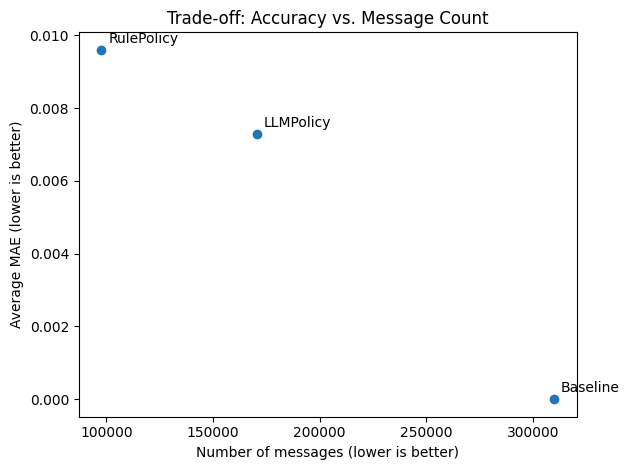

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) enter your metrics here (edit as you run new experiments)
runs = [
    {"policy":"Baseline",  "bytes":29750496, "msgs":309901, "time":1.515, "avg_mae":0.0,      "max_q":65},
    {"policy":"RulePolicy","bytes":6539280,  "msgs":97730,  "time":0.350, "avg_mae":0.0096,  "max_q":3},
    {"policy":"LLMPolicy", "bytes":13929792, "msgs":170593, "time":0.670, "avg_mae":0.0073, "max_q":54},
]

# 2) build df
df = pd.DataFrame(runs).set_index("policy")
display(df)

# 3) your scatter: messages vs. MAE
plt.figure()
plt.scatter(df["msgs"], df["avg_mae"])
for name, row in df.iterrows():
    plt.annotate(name, (row["msgs"], row["avg_mae"]), xytext=(5,5), textcoords="offset points")
plt.xlabel("Number of messages (lower is better)")
plt.ylabel("Average MAE (lower is better)")
plt.title("Trade-off: Accuracy vs. Message Count")
plt.tight_layout()
plt.show()
